In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import xarray as xr
import numpy as np
from glob import glob
from yllib.function import mysom
from yllib.function import myfunc
from yllib.plot import plot_map
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
year1   = 1981
year2   = 2020
cold_months  = [10,11,12,1,2,3]
warm_months  = [4,5,6,7,8,9]
mapsize = (4,4)
factor  = ('z')
map_extent = [160,-20+360,25,90]
sig_level = 0.95

## KMeans clustering

In [3]:
# read patterns
ds = xr.open_dataset(f'som/hgt_ano_cold_{mapsize[0]}x{mapsize[1]}.nc')
ano_cold = ds['ano'].sel(variable='z500')
# ano_cold = ano_cold.sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))

ds = xr.open_dataset(f'som/hgt_ano_warm_{mapsize[0]}x{mapsize[1]}.nc')
ano_warm = ds['ano'].sel(variable='z500')
# ano_warm = ano_warm.sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))


In [4]:
ano_warm

<xarray.DataArray 'ano' (bmu: 16, latitude: 61, longitude: 191)>
[186416 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 150.0 151.0 152.0 153.0 ... 338.0 339.0 340.0
  * latitude   (latitude) float64 70.0 69.0 68.0 67.0 ... 13.0 12.0 11.0 10.0
    variable   <U4 'z500'
  * bmu        (bmu) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

In [5]:
from sklearn.cluster import KMeans

def kmean_cluster(data, k=4):
    # data = data.sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
    data = mysom.convert_to_1D(data)
    emulator = KMeans(
        n_clusters=k,
        random_state=199303,
    )
    emulator.fit(data.data)
    labels = emulator.labels_
    labels = xr.DataArray(labels, dims=['labels'], coords=[np.arange(mapsize[0]*mapsize[1])])
    return labels


In [6]:
label_cold = kmean_cluster(ano_cold)
label_warm = kmean_cluster(ano_warm)

#### Convert SOM BMU to Kmeans

In [7]:
# read bmu
bmu_cold = xr.open_dataset(f"som/cold_z_{mapsize[0]}x{mapsize[1]}.nc")['bmu']
bmu_warm = xr.open_dataset(f"som/warm_z_{mapsize[0]}x{mapsize[1]}.nc")['bmu']

def convert_som_to_kmeans(xbmu, xlab):
    for i in np.arange(mapsize[0]*mapsize[1]):
        xbmu = xr.where(xbmu==i, xlab[i]+1000, xbmu)
    xbmu = xbmu - 1000
    return xbmu
bmu_cold = convert_som_to_kmeans(bmu_cold, label_cold)
bmu_warm = convert_som_to_kmeans(bmu_warm, label_warm)
bmu_cold.name = 'bmu'
bmu_warm.name = 'bmu'
bmu_cold.to_netcdf(f"som/kmean_cold_z_{mapsize[0]}x{mapsize[1]}.nc")
bmu_warm.to_netcdf(f"som/kmean_warm_z_{mapsize[0]}x{mapsize[1]}.nc")

In [8]:
disp_order_cold = [1,0,3,2]
disp_order_warm = [3,1,2,0]

## Plot composite for HGT

### 1. Calculation

In [9]:
data = xr.open_dataset('data/hgt_daily_anomaly_globe.nc')
# select season
data_cold = data.sel(time=data['time.month'].isin(cold_months))
data_warm = data.sel(time=data['time.month'].isin(warm_months))

In [10]:
# data_cold = data_cold['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
# data_warm = data_warm['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
data_cold = data_cold['z500'].sel(latitude=slice(90,0))
data_warm = data_warm['z500'].sel(latitude=slice(90,0))

In [11]:
mean_cold_cluster, pct_cold = mysom.calc_cluster_mapsize_fast(data_cold, bmu_cold, mapsize=(2,2))
mean_warm_cluster, pct_warm = mysom.calc_cluster_mapsize_fast(data_warm, bmu_warm, mapsize=(2,2))

In [13]:
diff_cold = xr.concat(mean_cold_cluster, dim='bmu')#.to_array(dim='variable')
diff_warm = xr.concat(mean_warm_cluster, dim='bmu')#.to_array(dim='variable')
diff_cold.coords['bmu'] = np.arange(4)
diff_warm.coords['bmu'] = np.arange(4)
diff_cold.to_netcdf('som/hgt_cold_4x4_kmean.nc')
diff_warm.to_netcdf('som/hgt_warm_4x4_kmean.nc')

HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 46977908160640:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1567 in H5F_open(): unable to lock the file
    major: File accessibilty
    minor: Unable to open file
  #002: H5FD.c line 1640 in H5FD_lock(): driver lock request failed
    major: Virtual File Layer
    minor: Can't update object
  #003: H5FDsec2.c line 959 in H5FD_sec2_lock(): unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'
    major: File accessibilty
    minor: Bad file ID accessed


PermissionError: [Errno 13] Permission denied: b'/qfs/projects/windpower_wfip2uq/liuy351/S2S/notebook_4x4/som/hgt_cold_4x4_kmean.nc'

### load bootstrap data for significant test

In [14]:
quantile_cold = xr.open_dataset('som/hgt_quantile_cold.nc')['z500']
sig_cold = xr.where(np.abs(diff_cold)>quantile_cold.sel(quantile=sig_level), 1, 0)
quantile_warm = xr.open_dataset('som/hgt_quantile_warm.nc')['z500']
sig_warm = xr.where(np.abs(diff_warm)>quantile_warm.sel(quantile=sig_level), 1, 0)

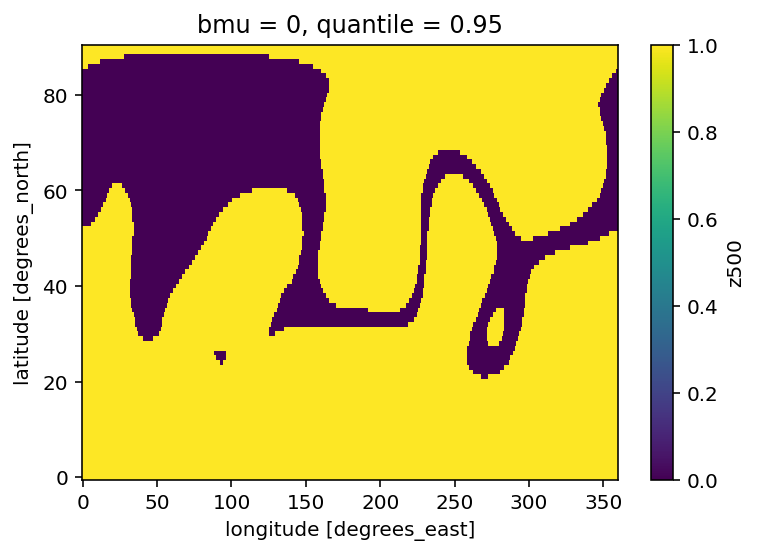

In [15]:
sig_cold.sel(bmu=0).plot()

In [16]:
# xr.merge([diff_cold, mean_cold, pval_cold]).to_netcdf(f'som/kmean_hgt_cold_{mapsize[0]}x{mapsize[1]}.nc')
# xr.merge([diff_warm, mean_warm, pval_warm]).to_netcdf(f'som/kmean_hgt_warm_{mapsize[0]}x{mapsize[1]}.nc')

### 2. Plot geopotential height

In [17]:
def plot_on_map(data, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  
    
    # create a figure
    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    
    # set map - extent, grid, coastline ...
    plot_map.set_map(
        ax,
        extent=[160,-20+360,25,90],
        # extent=[0,360,15,90],
        gridlines_kw=dict(
            xticks=[180,-120,-60],
            yticks=[0,20,40,60],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[],
            yticks=[],
        ),
        boundary_kw=dict(
            draw_state=False,
            coastline_kw=dict(linewidth=0.5, alpha=0.7, color='tab:gray'),
        ),
    )
    
    # lat and lon for contour plot
    lon, lat = data["longitude"], data["latitude"]
    
    # draw contourf
    cmap = kwargs.get('cmap', "WhiteBlueGreenYellowRed")
    clev = kwargs.get('clev', np.arange(0, 40, 1))
    cs, clev = plot_map.add_contourf(
        ax, lon, lat, data,
        cmap=cmap,clev=clev,
    )
    
    # draw contour
    xclev = [-90,-70,-50,-30,-10, 10,30,50,70,90]
    plot_map.add_contour(
        ax, lon, lat, data,
        colors=['k'], clev=xclev, alpha=0.7, linewidths=1.0,
    )
    
    
    # add text - title, ananote
    if (title:=kwargs.get('title')) is not None: 
        default_title_kwargs = dict(loc='left')
        default_title_kwargs.update(kwargs.get('title_kwargs', {}))
        ax.set_title(title, **default_title_kwargs)

    if kwargs.get('draw_colorbar'):
        plot_map.add_colorbar(cs, ax, clev[::10])
        
    return cs, clev

- pre-process for ploltting

In [18]:
def pre_plotting(data, pval):
    data = data/9.8
    data = data.where(pval==1)
    # data = data.where(np.abs(data)>=8)
    return data
diff_cold = pre_plotting(diff_cold, sig_cold)
diff_warm = pre_plotting(diff_warm, sig_warm)

# diff_warm, pval_warm = pre_plotting(diff_warm, pval_warm)
# diff_cold = diff_cold/9.8
# diff_warm = diff_warm/9.8
# plt.savefig("pdf/regimes_2x2.pdf", bbox_inches="tight", transparent=True)
# plt.savefig("pdf/regimes_2x2.png", bbox_inches="tight", dpi=150)

- plot

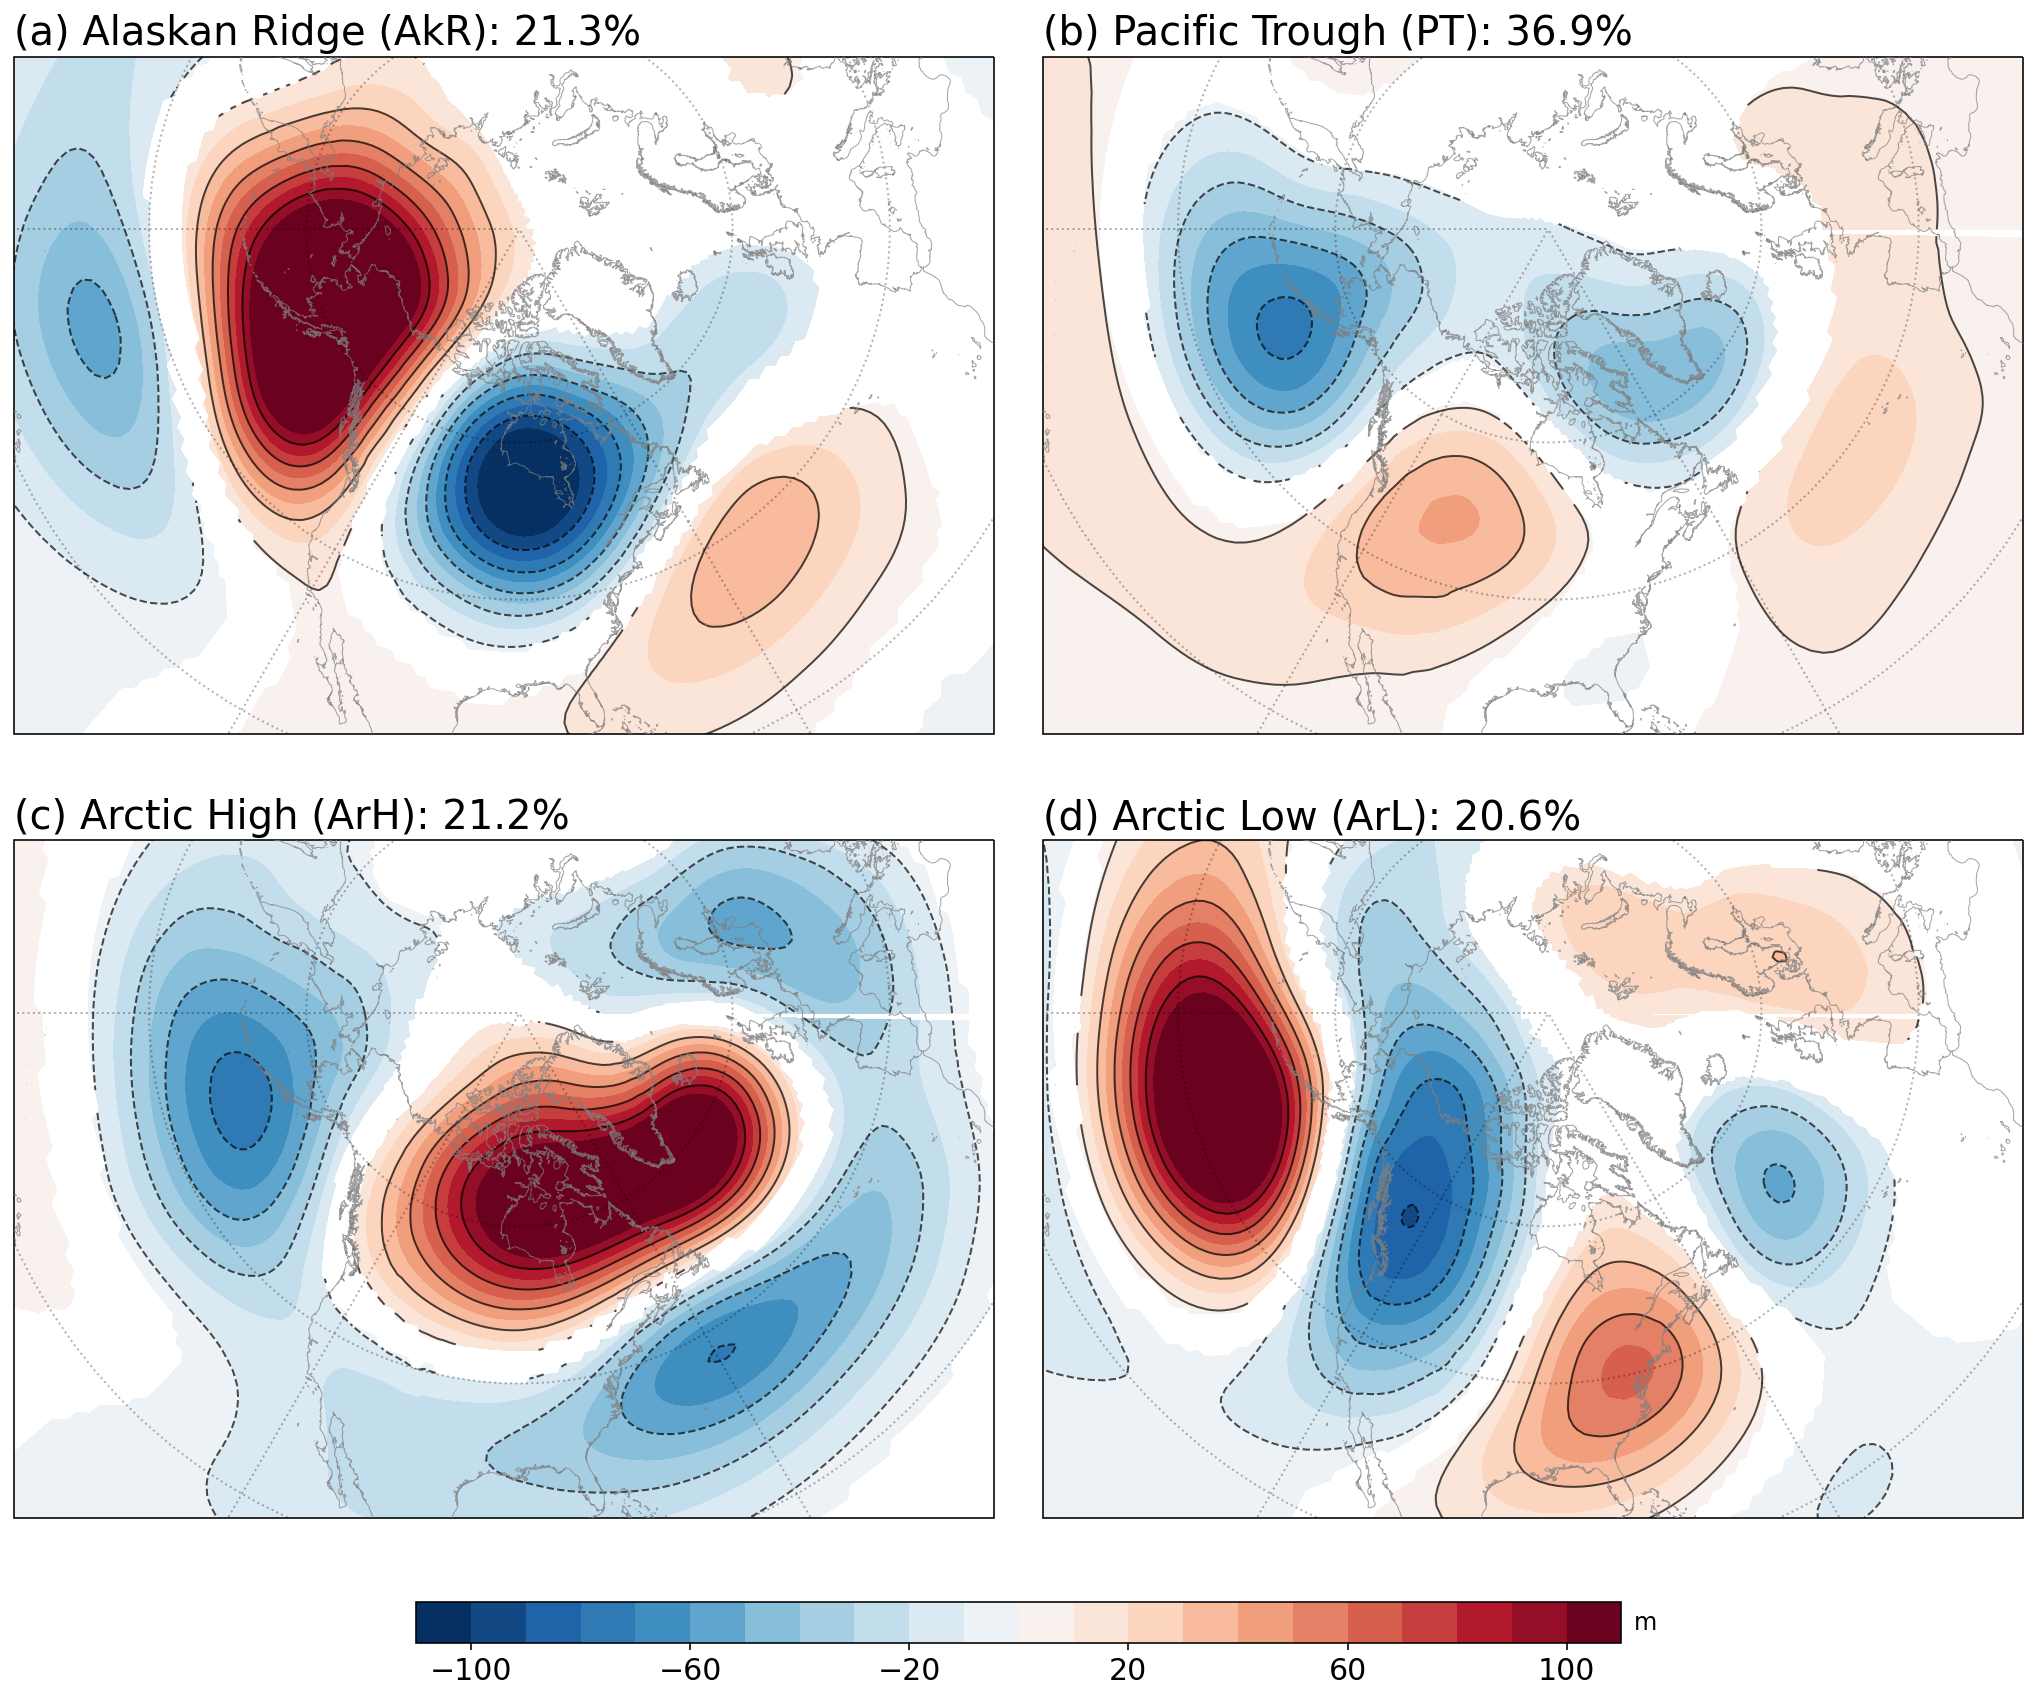

In [19]:
projection = ccrs.NorthPolarStereo(central_longitude=-90.0)
fig, axs = plt.subplots(
    2, 2, figsize=(15, 13), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.07, wspace=0.05)
axs = axs.ravel()
types = ['Alaskan Ridge (AkR)', 'Pacific Trough (PT)', 'Arctic High (ArH)', 'Arctic Low (ArL)']
abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(4):
    ax = axs[i]
    idisp = disp_order_cold[i]
    dispdata = diff_cold.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        fig=fig, ax=ax,
        clev=[-1000]+list(np.linspace(-100,100,21))+[1000],
        cmap='MPL_RdBu_r',
        title=f'({abcd[i]}) {types[i]}: {pct_cold[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
plot_map.add_colorbar(cs, axs, clev[1:-1:4], pad=0.05, shrink=0.6, units="m")
    

- Both cold and warm seasons

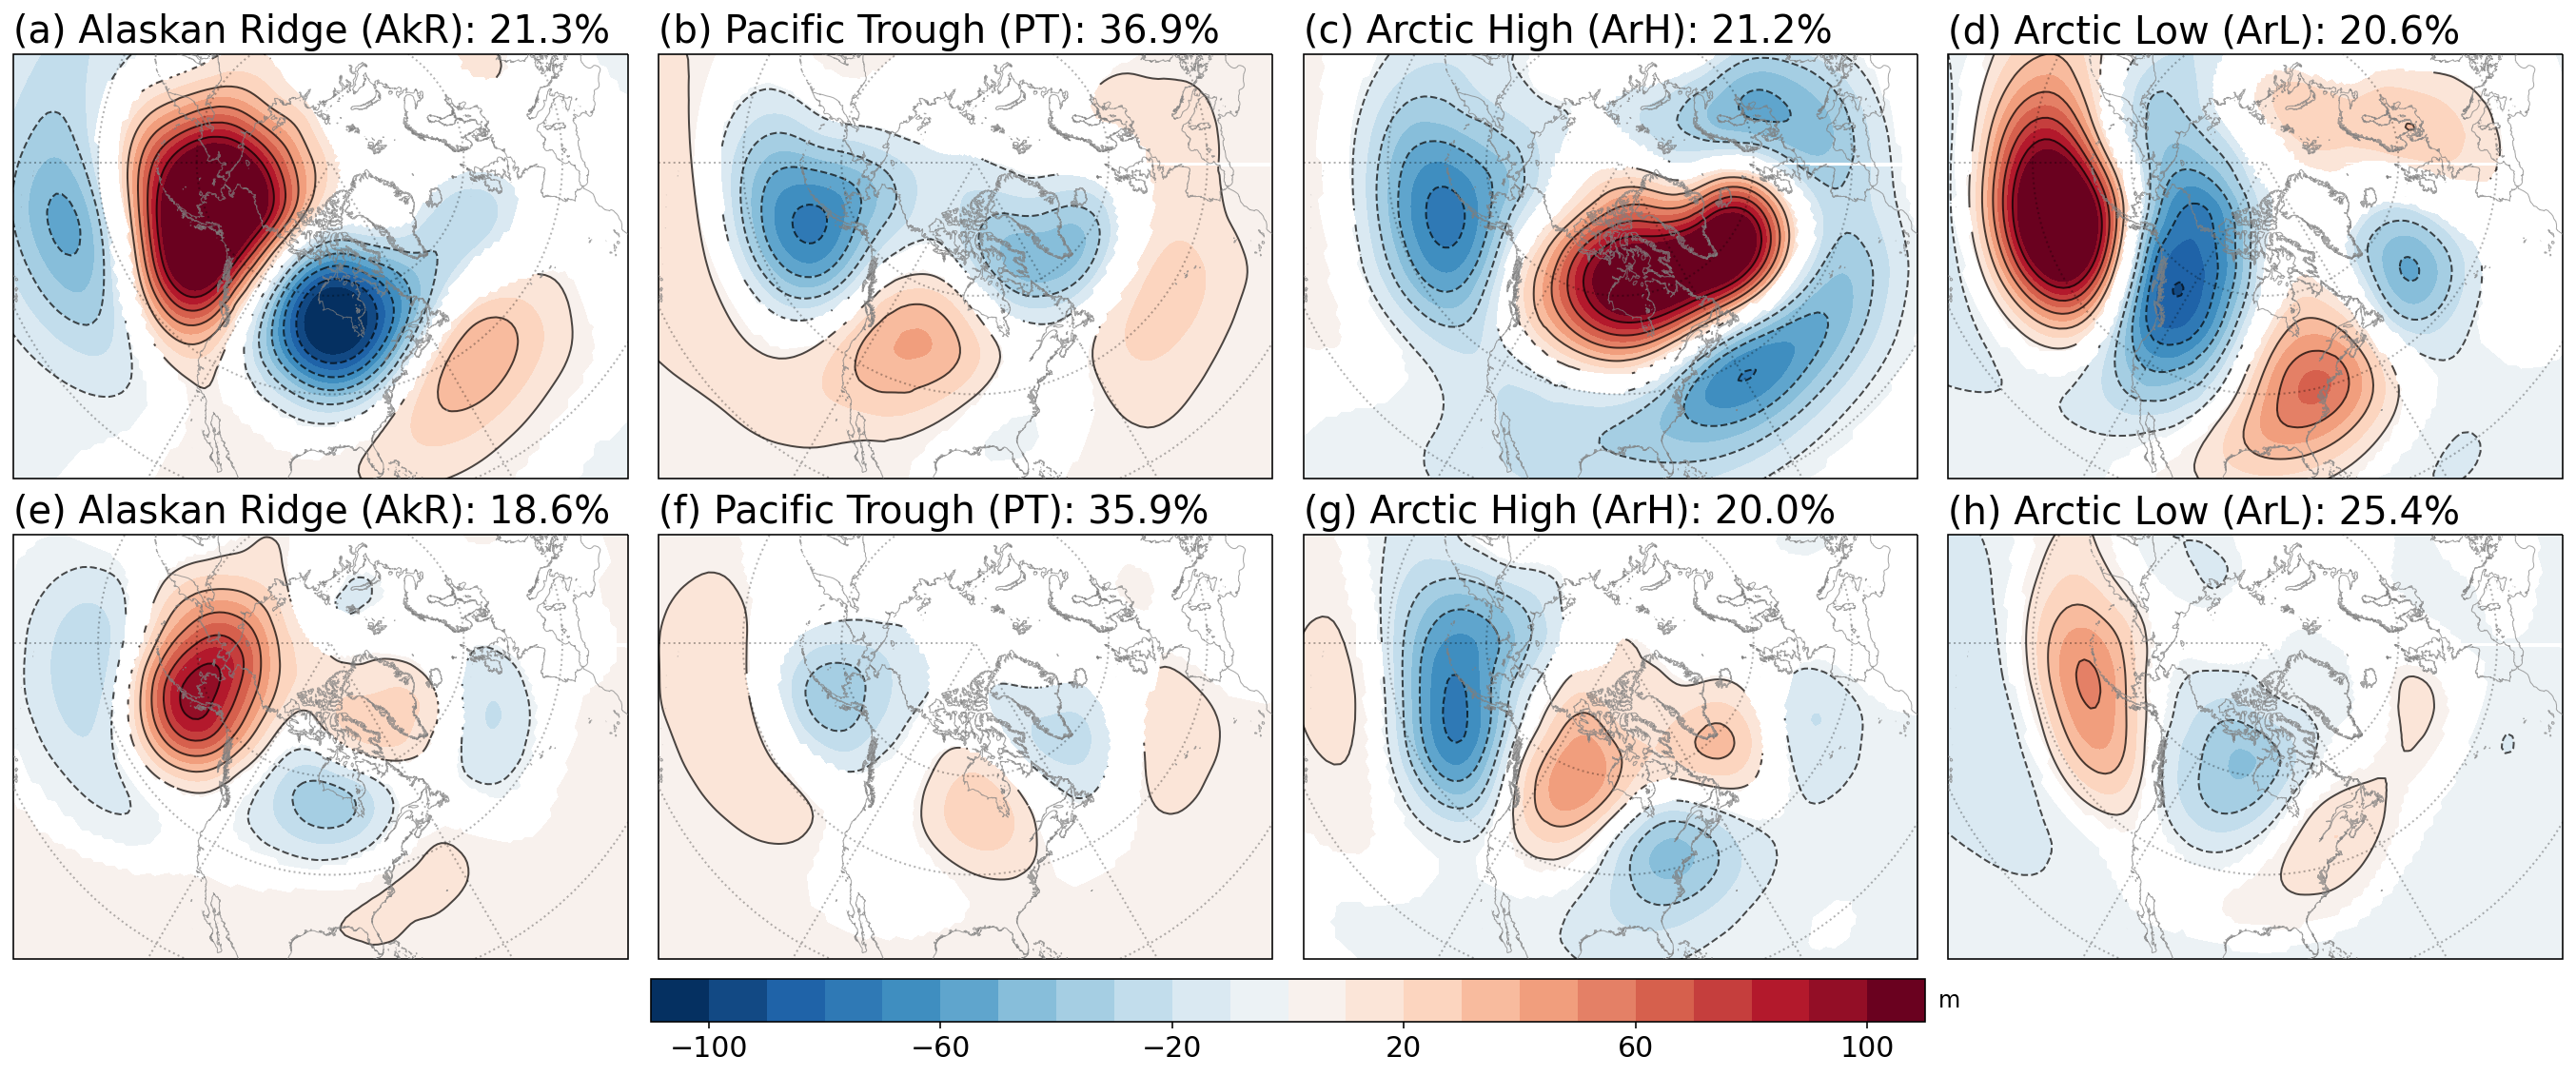

In [20]:
projection = ccrs.NorthPolarStereo(central_longitude=-90.0)
fig, axs = plt.subplots(
    2, 4, figsize=(20, 8), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.1, wspace=0.05)
axs = axs.ravel()
types = ['Alaskan Ridge (AkR)', 'Pacific Trough (PT)', 'Arctic High (ArH)', 'Arctic Low (ArL)']
abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(4):
    ax = axs[i]
    idisp = disp_order_cold[i]
    dispdata = diff_cold.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        fig=fig, ax=ax,
        clev=[-1000]+list(np.linspace(-100,100,21))+[1000],
        cmap='MPL_RdBu_r',
        title=f'({abcd[i]}) {types[i]}: {pct_cold[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
for i in np.arange(4):
    ax = axs[i+4]
    idisp = disp_order_warm[i]
    dispdata = diff_warm.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        fig=fig, ax=ax,
        clev=[-1000]+list(np.linspace(-100,100,21))+[1000],
        cmap='MPL_RdBu_r',
        title=f'({abcd[i+4]}) {types[i]}: {pct_warm[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
plot_map.add_colorbar(cs, axs, clev[1:-1:4], pad=0.02, shrink=0.5, units="m")

In [21]:
dispdata

<xarray.DataArray 'z500' (latitude: 91, longitude: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-6.3714166, -6.3584695, -6.3388247, ..., -6.382258 , -6.3734794,
        -6.373944 ],
       [-6.3691   , -6.353238 , -6.3330235, ..., -6.383496 , -6.3739457,
        -6.3708844],
       [-6.3511515, -6.3413177, -6.321798 , ..., -6.3823824, -6.3695884,
        -6.355501 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float64 90.0 89.0 88.0 87.0 86.0 ... 3.0 2.0 1.0 0.0
    bmu        int64 0
    quantile   float64 0.95

## Plot composite for wind speed

### 1. Calculation

In [22]:
map_extent = [-125+360,-70+360,25,50]
data = xr.open_dataset('data/wind_daily_anomaly_us.nc')
# select season
data_cold = data.sel(time=data['time.month'].isin(cold_months))
data_warm = data.sel(time=data['time.month'].isin(warm_months))

In [23]:
# data_cold = data_cold['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
# data_warm = data_warm['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
data_cold = data_cold['VAR_100UV'].sel(longitude=slice(220,-50+360), latitude=slice(55,20))
data_warm = data_warm['VAR_100UV'].sel(longitude=slice(220,-50+360), latitude=slice(55,20))

In [24]:
mean_cold_cluster, pct_cold = mysom.calc_cluster_mapsize_fast(data_cold, bmu_cold, mapsize=(2,2))
mean_warm_cluster, pct_warm = mysom.calc_cluster_mapsize_fast(data_warm, bmu_warm, mapsize=(2,2))

In [25]:
diff_cold = xr.concat(mean_cold_cluster, dim='bmu')#.to_array(dim='variable')
diff_warm = xr.concat(mean_warm_cluster, dim='bmu')#.to_array(dim='variable')
diff_cold.coords['bmu'] = np.arange(4)
diff_warm.coords['bmu'] = np.arange(4)
diff_cold.to_netcdf('som/wind_cold_4x4_kmean.nc')
diff_warm.to_netcdf('som/wind_warm_4x4_kmean.nc')

### load bootstrap data for significant test

In [26]:
quantile_cold = xr.open_dataset('som/wind_quantile_cold.nc')['VAR_100UV']
sig_cold = xr.where(np.abs(diff_cold)>quantile_cold.sel(quantile=sig_level), 1, 0)
quantile_warm = xr.open_dataset('som/wind_quantile_warm.nc')['VAR_100UV']
sig_warm = xr.where(np.abs(diff_warm)>quantile_warm.sel(quantile=sig_level), 1, 0)

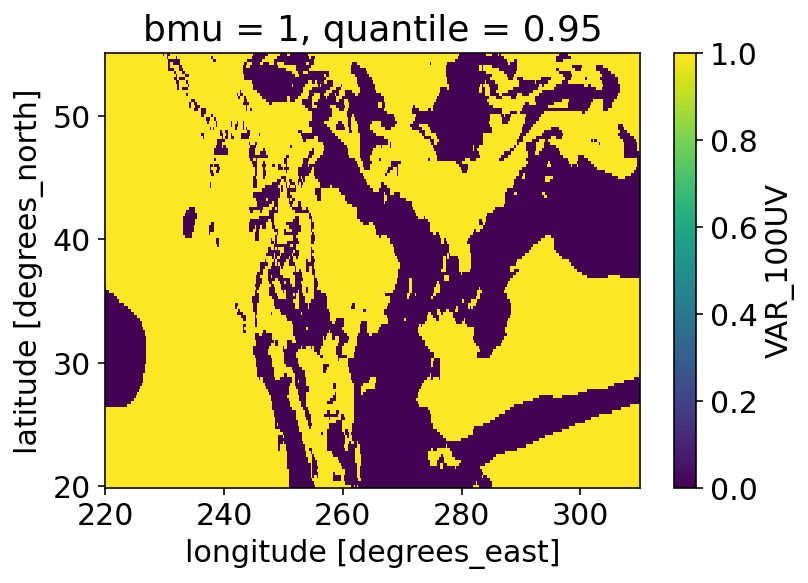

In [27]:
sig_cold.sel(bmu=1).plot()

### 2. Plot geopotential height

In [28]:
def mask_keep_us(data):
    mask = xr.open_dataset("mask_us.nc")["mask"]
    mask = mask.sel(latitude=data.latitude, longitude=data.longitude)
    data.coords["mask"] = mask
    data = data.where(mask==1)
    del data.coords["mask"]
    return data

def plot_on_map(data, dot, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  
    
    # create a figure
    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    
    # set map - extent, grid, coastline ...
    plot_map.set_map(
        ax,
        extent=[-125+360,-70+360,25,50],
        # extent=[0,360,15,90],
        gridlines_kw=dict(
            xticks=[-120,-100,-80,-60],
            yticks=[20,30,40],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[],
            yticks=[],
        ),
        boundary_kw=dict(
            draw_state=True,
            coastline_kw=dict(linewidth=0.9, alpha=0.7, color='k'),
            draw_borders=True,
            border_kw=dict(linewidth=0.9, alpha=0.7, color='k'),
        ),
    )
    
    # lat and lon for contour plot
    lon, lat = data["longitude"], data["latitude"]
    
    # draw contourf
    cmap = kwargs.get('cmap', "WhiteBlueGreenYellowRed")
    clev = kwargs.get('clev', np.arange(0, 40, 1))
    cs, clev = plot_map.add_contourf(
        ax, lon, lat, data,
        cmap=cmap,clev=clev,
    )
    
    _, _ = plot_map.add_hatches(ax,
                    lon, lat, dot,
                    clev=[0.5,1],
                    hatches=["..."],
                    color="tab:gray",
                   )
    
    # draw contour
#     xclev = [-90,-70,-50,-30,-10, 10,30,50,70,90]
#     plot_map.add_contour(
#         ax, lon, lat, data,
#         colors=['k'], clev=xclev, alpha=0.7, linewidths=1.0,
#     )
    
    
    # add text - title, ananote
    if (title:=kwargs.get('title')) is not None: 
        default_title_kwargs = dict(loc='left')
        default_title_kwargs.update(kwargs.get('title_kwargs', {}))
        ax.set_title(title, **default_title_kwargs)

    if kwargs.get('draw_colorbar'):
        plot_map.add_colorbar(cs, ax, clev[::10])
        
    return cs, clev

- pre-process for ploltting

In [29]:
diff_cold = mask_keep_us(diff_cold)
diff_warm = mask_keep_us(diff_warm)
sig_cold = mask_keep_us(sig_cold)
sig_warm = mask_keep_us(sig_warm)
# plt.savefig("pdf/regimes_2x2.pdf", bbox_inches="tight", transparent=True)
# plt.savefig("pdf/regimes_2x2.png", bbox_inches="tight", dpi=150)

- plot

/people/liuy351/software/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


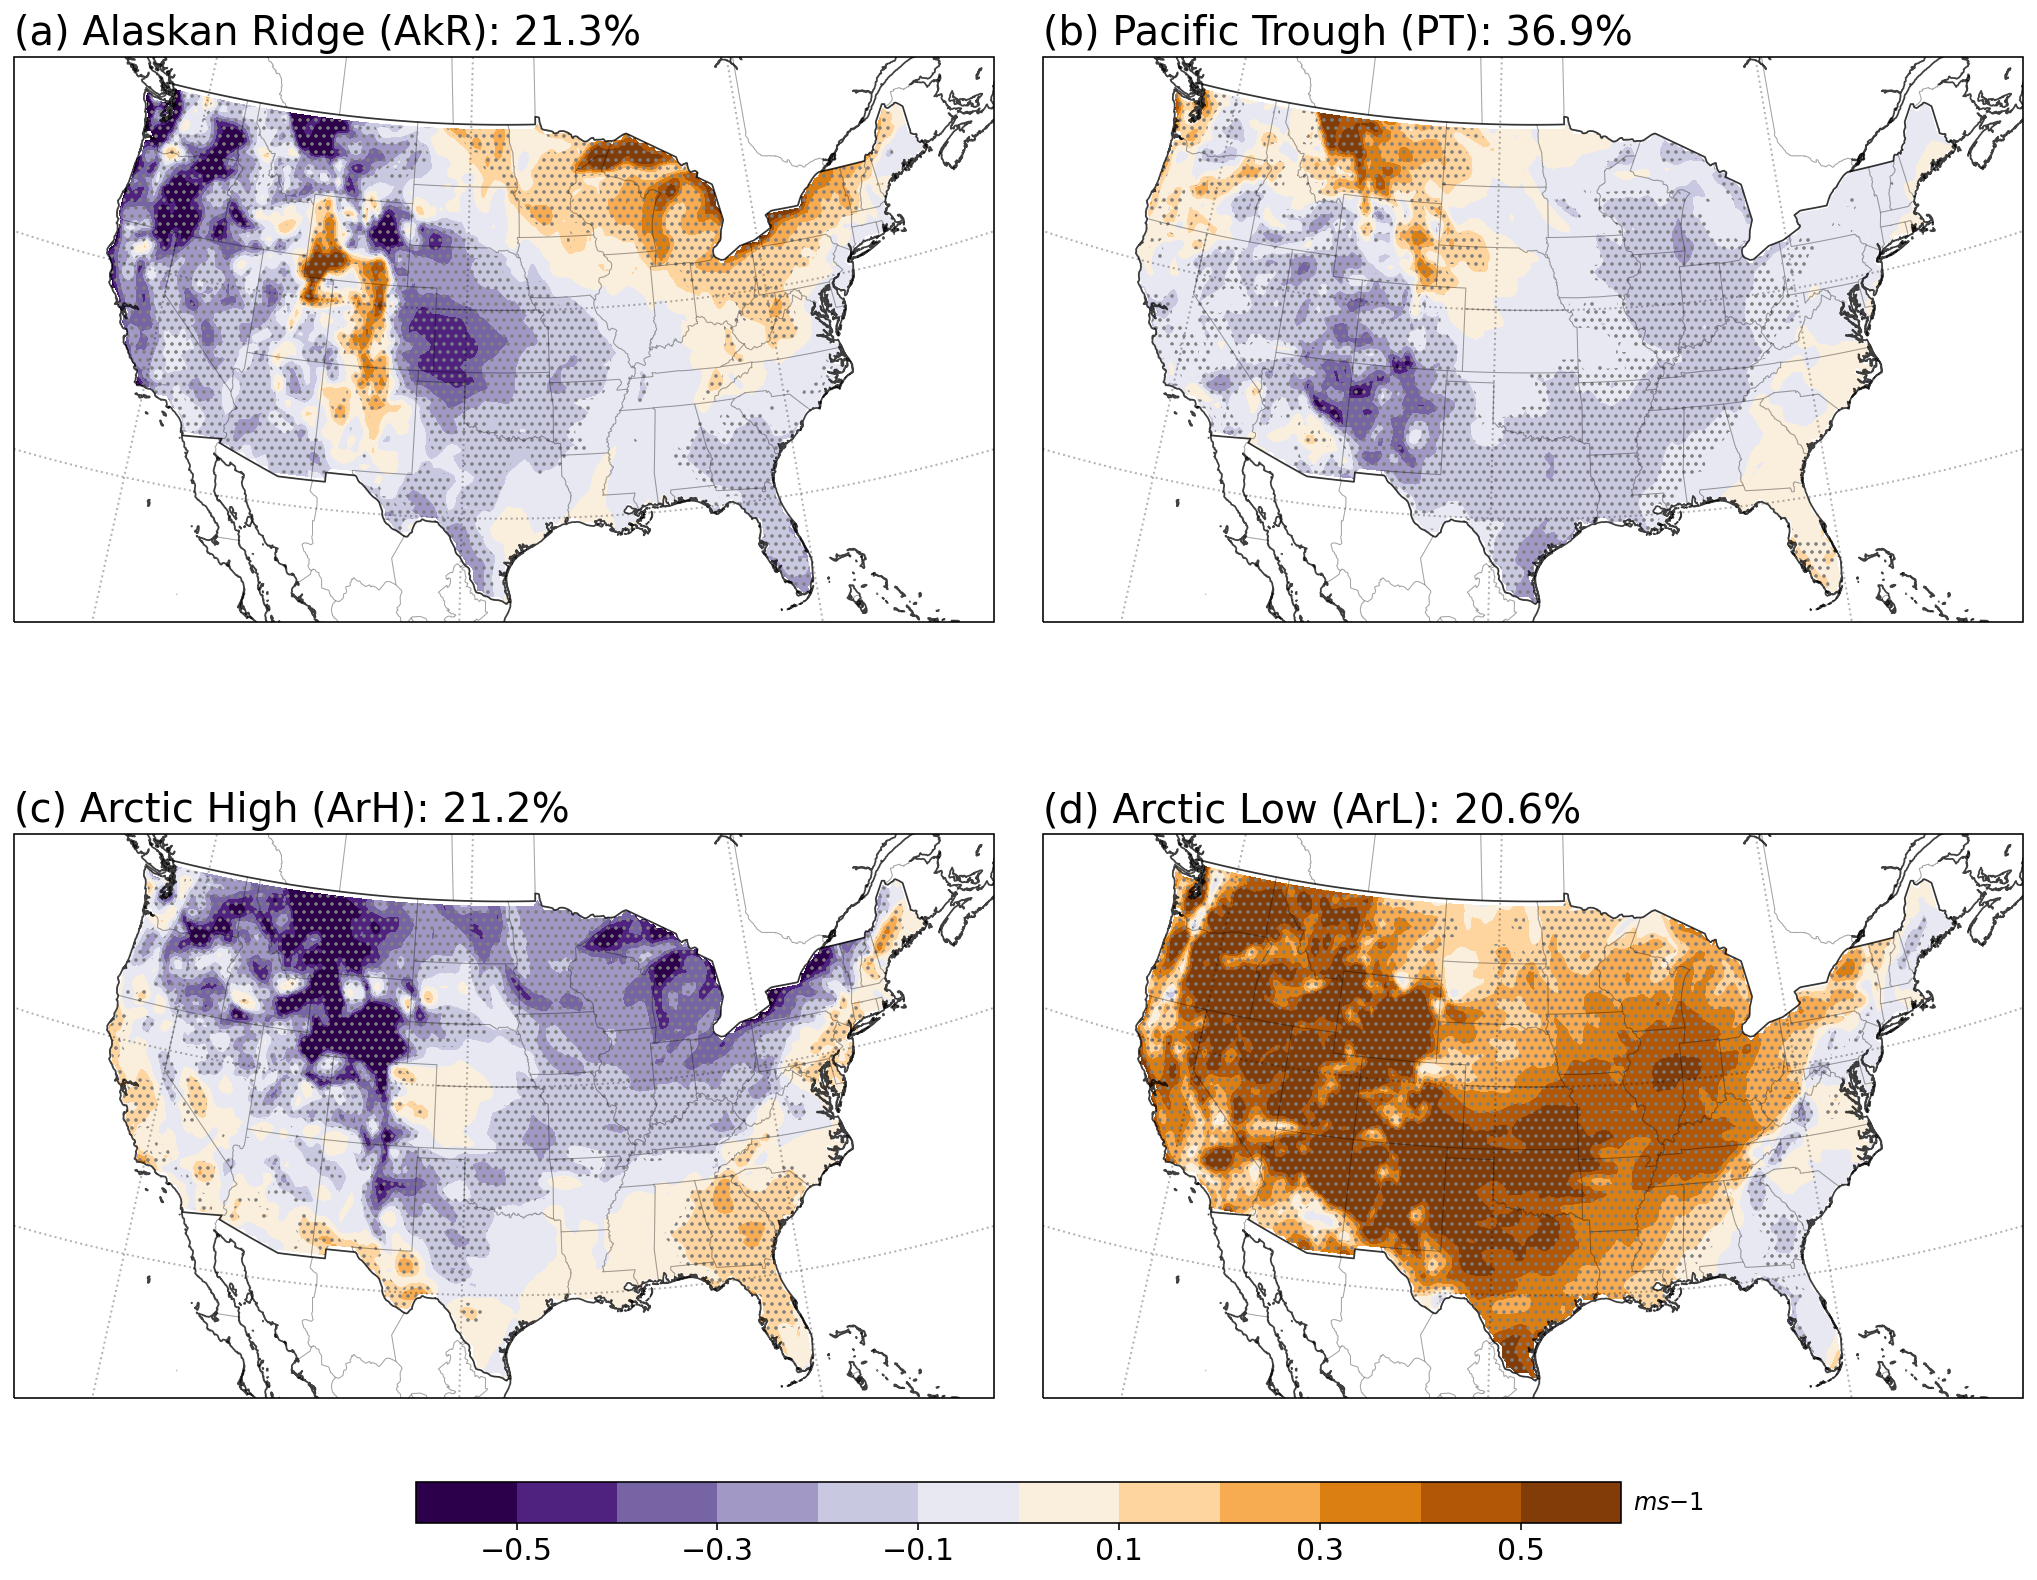

In [30]:
central_lon = np.mean(map_extent[:2])
central_lat = np.mean(map_extent[2:])
projection  = ccrs.AlbersEqualArea(central_lon, central_lat)
fig, axs = plt.subplots(
    2, 2, figsize=(15, 13), 
    subplot_kw={'projection': projection}
)
axs = axs.ravel()
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.05, wspace=0.05)
types = ['Alaskan Ridge (AkR)', 'Pacific Trough (PT)', 'Arctic High (ArH)', 'Arctic Low (ArL)']
abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(4):
    ax = axs[i]
    idisp = disp_order_cold[i]
    dispdata = diff_cold.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        sig_cold.sel(bmu=idisp),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(-0.5,0.5,11))+[100],
        cmap='MPL_PuOr_r',
        title=f'({abcd[i]}) {types[i]}: {pct_cold[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
plot_map.add_colorbar(cs, axs, clev[1:-1:2], pad=0.05, shrink=0.6, units="$ms{-1}$")
    

- Both cold and warm seasons

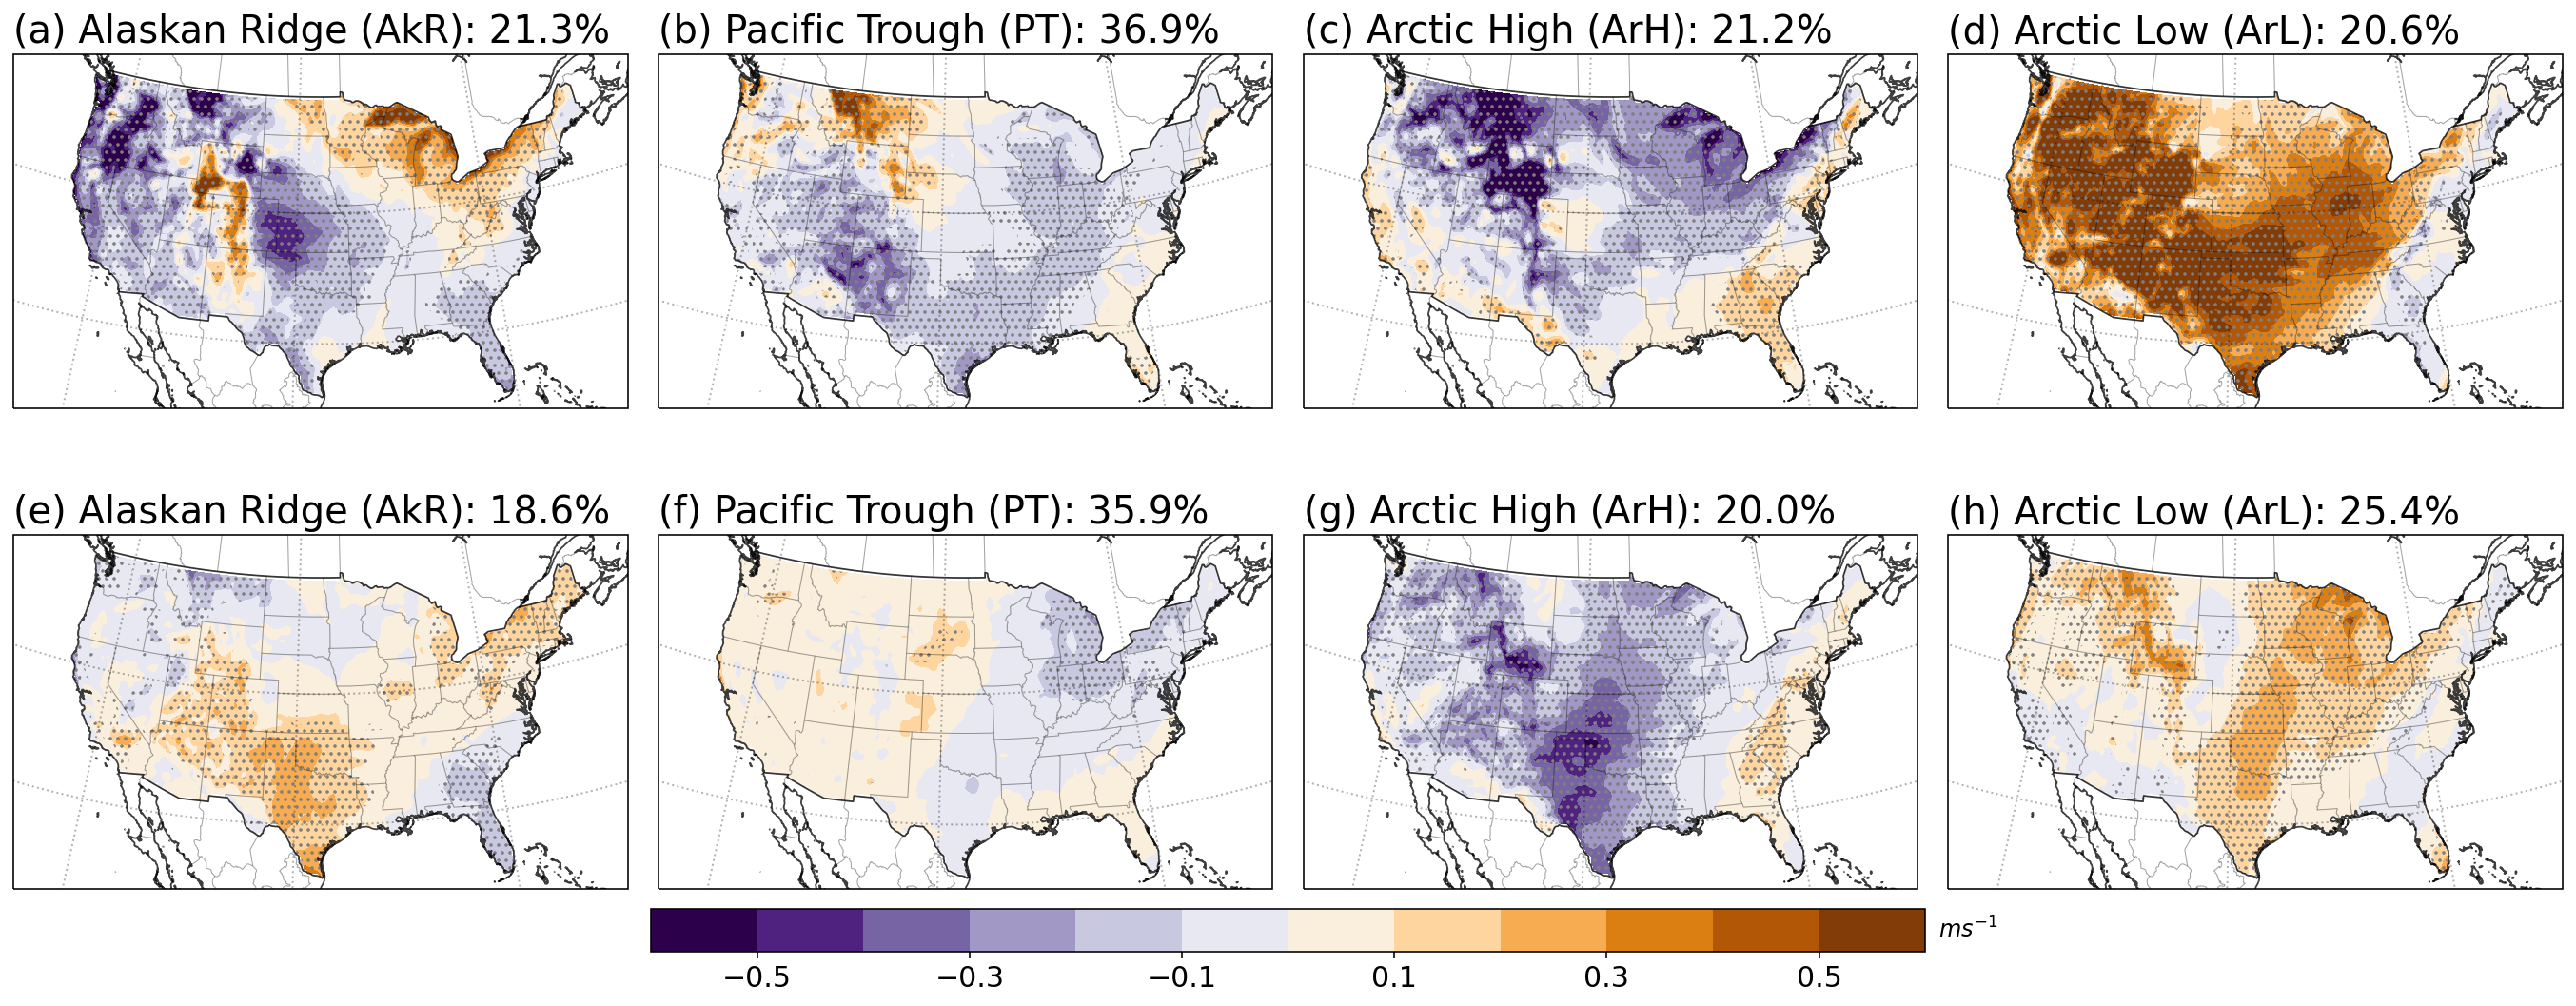

In [31]:
central_lon = np.mean(map_extent[:2])
central_lat = np.mean(map_extent[2:])
projection  = ccrs.AlbersEqualArea(central_lon, central_lat)
fig, axs = plt.subplots(
    2, 4, figsize=(20, 8), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.1, wspace=0.05)
axs = axs.ravel()
types = ['Alaskan Ridge (AkR)', 'Pacific Trough (PT)', 'Arctic High (ArH)', 'Arctic Low (ArL)']
abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(4):
    ax = axs[i]
    idisp = disp_order_cold[i]
    dispdata = diff_cold.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        sig_cold.sel(bmu=idisp),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(-0.5,0.5,11))+[100],
        cmap='MPL_PuOr_r',
        title=f'({abcd[i]}) {types[i]}: {pct_cold[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
for i in np.arange(4):
    ax = axs[i+4]
    idisp = disp_order_warm[i]
    dispdata = diff_warm.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        sig_warm.sel(bmu=idisp),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(-0.5,0.5,11))+[100],
        cmap='MPL_PuOr_r',
        title=f'({abcd[i+4]}) {types[i]}: {pct_warm[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
plot_map.add_colorbar(cs, axs, clev[1:-1:2], pad=0.02, shrink=0.5, units="$ms^{-1}$")


### relative changes in wind speed

In [ ]:
map_extent = [-125+360,-70+360,25,50]
data = xr.open_dataset('data/wind_daily_relative_anomaly_us.nc')
# select season
data_cold = data.sel(time=data['time.month'].isin(cold_months))
data_warm = data.sel(time=data['time.month'].isin(warm_months))

In [ ]:
# data_cold = data_cold['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
# data_warm = data_warm['z500'].sel(latitude=slice(*map_extent[2:][::-1]), longitude=slice(*map_extent[:2]))
data_cold = data_cold['VAR_100UV'].sel(longitude=slice(220,-50+360), latitude=slice(55,20)) * 100.
data_warm = data_warm['VAR_100UV'].sel(longitude=slice(220,-50+360), latitude=slice(55,20)) * 100.

In [ ]:
mean_cold_cluster, pct_cold = mysom.calc_cluster_mapsize_fast(data_cold, bmu_cold, mapsize=(2,2))
mean_warm_cluster, pct_warm = mysom.calc_cluster_mapsize_fast(data_warm, bmu_warm, mapsize=(2,2))

In [ ]:
diff_cold = xr.concat(mean_cold_cluster, dim='bmu')#.to_array(dim='variable')
diff_warm = xr.concat(mean_warm_cluster, dim='bmu')#.to_array(dim='variable')
diff_cold.coords['bmu'] = np.arange(4)
diff_warm.coords['bmu'] = np.arange(4)

In [ ]:
diff_cold = mask_keep_us(diff_cold)
diff_warm = mask_keep_us(diff_warm)

In [ ]:
central_lon = np.mean(map_extent[:2])
central_lat = np.mean(map_extent[2:])
projection  = ccrs.AlbersEqualArea(central_lon, central_lat)
fig, axs = plt.subplots(
    2, 4, figsize=(20, 8), 
    subplot_kw={'projection': projection}
)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.1, wspace=0.05)
axs = axs.ravel()
types = ['Alaskan Ridge (AkR)', 'Pacific Trough (PT)', 'Arctic High (ArH)', 'Arctic Low (ArL)']
abcd = list('abcdefghijklmnop')
# for ax in axs: ax.set_axis_off()
for i in np.arange(4):
    ax = axs[i]
    idisp = disp_order_cold[i]
    dispdata = diff_cold.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        sig_cold.sel(bmu=idisp),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(-50,50,11))+[100],
        cmap='MPL_PuOr_r',
        title=f'({abcd[i]}) {types[i]}: {pct_cold[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
for i in np.arange(4):
    ax = axs[i+4]
    idisp = disp_order_warm[i]
    dispdata = diff_warm.sel(bmu=idisp)#, variable='z500')
    cs, clev = plot_on_map(
        dispdata,
        sig_warm.sel(bmu=idisp),
        fig=fig, ax=ax,
        clev=[-100]+list(np.linspace(-10,10,11))+[100],
        cmap='MPL_PuOr_r',
        title=f'({abcd[i+4]}) {types[i]}: {pct_warm[idisp]:.1f}%',
        title_kwargs=dict(fontsize=20),
    )
plot_map.add_colorbar(cs, axs, clev[1:-1:2], pad=0.02, shrink=0.5, units="(%)")